In [77]:
import pandas as pd

GIT = 'https://github.com/tyokokur/tmpdat/raw/main/nfh/'
dat = pd.read_csv(GIT+'NFH_train.txt', sep='\s+', names=['parent','chiname','b','v',
                                                         'cs','gH','tH0','tH1','tH2','tH3'])
chimax = [float(i.split('.')[2][2:]) / 100 for i in dat.chiname.values]
to_train = dat.iloc[:,2:].join(pd.Series(chimax, name='chimax'))
to_train = to_train[['b','v','chimax','cs','gH','tH0','tH1','tH2','tH3']]
display(to_train)

,b,v,chimax,cs,gH,tH0,tH1,tH2,tH3
0,2.2,1.20,3.10,0.004,37.76,89.82,84.25,77.82,69.56
1,2.2,1.20,3.10,0.005,27.73,80.27,74.45,67.77,59.27
2,2.2,1.20,3.10,0.006,22.46,71.73,65.75,58.97,50.65
3,2.2,1.20,3.10,0.008,18.72,62.46,56.79,50.55,43.16
4,2.2,1.20,3.10,0.010,16.57,57.21,51.86,45.95,38.91
...,...,...,...,...,...,...,...,...,...
585,2.5,1.25,3.15,0.015,14.60,52.64,46.77,40.23,32.48
586,2.5,1.25,3.15,0.020,12.81,46.76,40.83,34.17,26.35
587,2.5,1.25,3.15,0.030,11.55,39.16,33.16,26.67,19.67
588,2.5,1.25,3.15,0.040,11.03,34.76,29.04,23.13,17.11


In [80]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input  = torch.tensor(to_train.iloc[:,:4].values, dtype=torch.float32)
train_target = torch.tensor(to_train.gH.values,  dtype=torch.float32).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
b_test = torch.linspace(0.1, 2.5, 50)
v_test = torch.linspace(0.1, 2.5, 50)
ch_test = torch.linspace(2.8, 4.0, 50)
cs_test = torch.logspace(-3, 2, 50)
B, V, CH, CS = torch.meshgrid(b_test, v_test, ch_test, cs_test)

# Compute curve predictions for test input values
test_input = torch.stack([B.flatten(), V.flatten(), CH.flatten(), CS.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(B.shape)

Epoch 0, loss 674.3014526367188
Epoch 1000, loss 13.850899696350098
Epoch 2000, loss 7.612743377685547
Epoch 3000, loss 4.664754867553711
Epoch 4000, loss 4.796411991119385
Epoch 5000, loss 2.5748112201690674
Epoch 6000, loss 2.3535258769989014
Epoch 7000, loss 2.325639009475708
Epoch 8000, loss 3.4405980110168457
Epoch 9000, loss 2.7180111408233643


0.58979595 0.29591838 3.044898


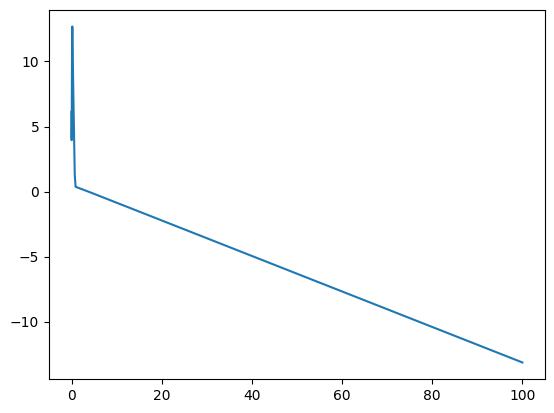

In [88]:
bind, vind, chind = 10, 4, 10
print(b_test[bind].numpy(), v_test[vind].numpy(), ch_test[chind].numpy())

plt.subplots(1,1)
plt.plot(cs_test[:], curve_predictions[bind, vind, chind,:])

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Globals ##
n_in  = 2
n_out = 1


# Define the target function
def target_function(x, y):
    return x**2 - y**3


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    global n_in
    global n_out 
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_in, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, n_out)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input = torch.empty(1000, n_in).uniform_(0, 1)
train_target = target_function(train_input[:, 0], train_input[:, 1]).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
x_test = torch.linspace(0, 1, 100)
y_test = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x_test, y_test)

# Compute curve predictions for test input values
test_input = torch.stack([X.flatten(), Y.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(X.shape)

# Plot the true curve and predicted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.contourf(X, Y, target_function(X, Y), levels=20, cmap='viridis')
ax.set_title('True Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the predicted curve
ax = fig.add_subplot(122)
ax.contourf(X, Y, curve_predictions, levels=20, cmap='viridis')
ax.set_title('Predicted Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Show the plot
plt.show()

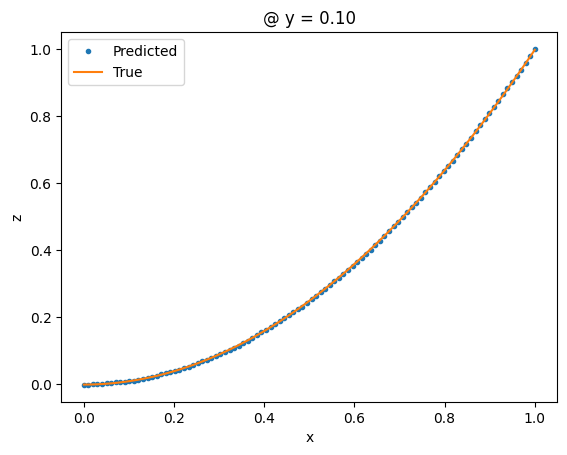

In [2]:
f, ax = plt.subplots(1,1)
yind = 10
ax.plot(X[:,yind], curve_predictions[:,yind], 'o', ms=3, label='Predicted')
ax.plot(X[:,yind], target_function(X[:,yind], Y[:,yind]), label='True')
ax.set_title('@ y = {:.2f}'.format(Y[0, yind].numpy()))
ax.set_ylabel('z')
ax.set_xlabel('x')

plt.legend()
plt.show()